In [2]:
import rasterio
import os
import shutil
from distutils.dir_util import copy_tree

In [3]:
evaltile="tile"
modistile="h11v10"

indir = os.path.join(r"E:\acocac\research",evaltile,r"terrai\ascii",modistile,"dates")
outdir = os.path.join(r"E:\acocac\research",evaltile,r"terrai\ascii",modistile,"merge")

In [4]:
dirs = sorted(os.listdir(indir))

In [5]:
for x, dirname in enumerate(dirs):

    badprefix = 'unknown_' + dirname + '_'
    fnames = os.listdir(os.path.join(indir,dirname))

    for fname in fnames:
        if fname.startswith(badprefix):
            os.rename(os.path.join(indir,dirname,fname), os.path.join(indir,dirname,fname).replace(badprefix, '', 1))
        dirname,
    try:
        copy_tree(os.path.join(indir,dirname), outdir)
    # Directories are the same
    except shutil.Error as e:
        print('Directory not copied. Error: %s' % e)
    # Any error saying that the directory doesn't exist
    except OSError as e:
        print('Directory not copied. Error: %s' % e)

## part 2

In [1]:
from glob import glob
import rasterio
import os
from math import floor, ceil
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import datetime
import math

In [2]:
evaltile="tile"
modistile="h13v10"
year = 2007
scheme = 'Copernicusnew_all'

probdir = os.path.join(r"E:\acocac\research",evaltile,r"terrai\ascii",modistile,"merge")
clu_fn = os.path.join(r"E:\acocac\research",evaltile,"clusters","clcp1_" + scheme + "_" + str(year) + "-" + str(year) + "_raw_c5.asc")

In [3]:
def read_file(lon, lat, file):
    with rasterio.open(file) as src:
        window = longlat2window(lon, lat, src)
        return(src.read(1, window=window))

In [4]:
def read_file_regular(file):
    with rasterio.open(file) as src:
        return(src.read(1))

In [5]:
def longlat2window(lon, lat, dataset): #source: https://gis.stackexchange.com/questions/298345/making-subset-of-sentinel-2-with-rasterio
    """
    Args:
        lon (tuple): Tuple of min and max lon
        lat (tuple): Tuple of min and max lat
        dataset: Rasterio dataset

    Returns:
        rasterio.windows.Window
    """
#     p = Proj(init='epsg:4326')
    t = dataset.transform
    xmin, ymin = lon[0], lat[0]
    xmax, ymax = lon[1], lat[1]
    col_min, row_min = ~t * (xmin, ymin)
    col_max, row_max = ~t * (xmax, ymax)
    return rasterio.windows.Window.from_slices(rows=(floor(row_max), ceil(row_min)),
                              cols=(floor(col_min), ceil(col_max)))

In [6]:
def maskclu(array, mask):
    return(np.ma.array(array, mask = ~mask))

In [7]:
def Make_TimeStamps(Startdate,Enddate):
    '''
    This function determines all time steps of which the FPAR must be downloaded
    The time stamps are 16 daily.
    Keywords arguments:
    Startdate -- 'yyyy-mm-dd'
    Enddate -- 'yyyy-mm-dd'
    '''

    # Define the DOY and year of the start day
    DOY = datetime.datetime.strptime(Startdate,'%Y-%m-%d').timetuple().tm_yday
    Year = datetime.datetime.strptime(Startdate,'%Y-%m-%d').timetuple().tm_year

    # Define the year of the end day
    YearEnd = datetime.datetime.strptime(Enddate,'%Y-%m-%d').timetuple().tm_year

    # Change the DOY of the start day into a DOY of MODIS day (8-daily) and create new startdate
    DOYstart = int(math.floor(DOY / 16.0) * 16) + 1
    DOYstart = str('%s-%s' %(DOYstart, Year))
    Day = datetime.datetime.strptime(DOYstart, '%j-%Y')
    Month = '%02d' % Day.month
    Day = '%02d' % Day.day
    Startdate = (str(Year) + '-' + str(Month) + '-' + str(Day))

    # Create the start and end data for the whole year
    YearStartDate = pd.date_range(Startdate, Enddate, freq = 'AS')
    YearEndDate = pd.date_range(Startdate, Enddate, freq = 'A')

    # Define the amount of years that are involved
    AmountOfYear = YearEnd - Year

    # If the startday is not in the same year as the enddate
    if AmountOfYear > 0:
        for i in range(0, AmountOfYear+1):
            if i is 0:
                Startdate1 = Startdate
                Enddate1 = YearEndDate[0]
                Dates = pd.date_range(Startdate1, Enddate1, freq = '16D')
            if i is AmountOfYear:
                Startdate1 = YearStartDate[-1]
                Enddate1 = Enddate
                Dates1 = pd.date_range(Startdate1, Enddate1, freq = '16D')
                Dates = Dates.union(Dates1)
            if (i is not AmountOfYear and i is not 0):
                Startdate1 = YearStartDate[i-AmountOfYear-1]
                Enddate1 = YearEndDate[i]
                Dates1 = pd.date_range(Startdate1, Enddate1, freq = '16D')
                Dates = Dates.union(Dates1)

    # If the startday is in the same year as the enddate
    if AmountOfYear is 0:
        Dates = pd.date_range(Startdate, Enddate, freq = '16D')

    return(Dates)

In [8]:
cluster =  rasterio.open(clu_fn)
xmin, ymin, xmax, ymax = cluster.bounds

lon = [xmin, xmax]
lat = [ymin, ymax]

In [9]:
file_list = glob(os.path.join(probdir, '*.asc'))

# Read all data as a list of numpy arrays 
# prob_list = [read_file(lon, lat, x) for x in file_list]
prob_list = [read_file_regular(x) for x in file_list]

In [10]:
def clus_data(file_list, prob_list, cluster_raster, cluster_val):
    mask = np.array(cluster_raster.read(1) == cluster_val)
    clus_list = [maskclu(x, mask) for x in prob_list]
    clust_stack = np.ma.stack(clus_list)
    dates_list = [os.path.basename(x) for x in file_list]
    dates_list = [os.path.splitext(x)[0] for x in dates_list]

    #reshape
    z = clust_stack.reshape((clust_stack.shape[0],clust_stack.shape[1]*clust_stack.shape[2]))

    tS = os.path.basename(file_list[0]).replace("_","-").replace(".asc","")
    tE = os.path.basename(file_list[-1]).replace("_","-").replace(".asc","")
    
#     df = pd.DataFrame(np.ma.compress_rowcols(z, axis=1), index=Make_TimeStamps(tS,tE))
    df = pd.DataFrame(np.ma.compress_rowcols(z, axis=1),index=dates_list)
  
    data=pd.melt(df.T)
#     data = data.set_index(pd.DatetimeIndex(pd.to_datetime(data['variable'])))
    data = data.set_index(pd.DatetimeIndex(pd.to_datetime(data['variable'], format="%Y_%m_%d")))
    data['year'] = data.index.year
    
    return(data)

In [241]:
# sns.boxplot(x="variable", y="value", data=data)

# plt.show()

In [11]:
categorical = range(1,6)

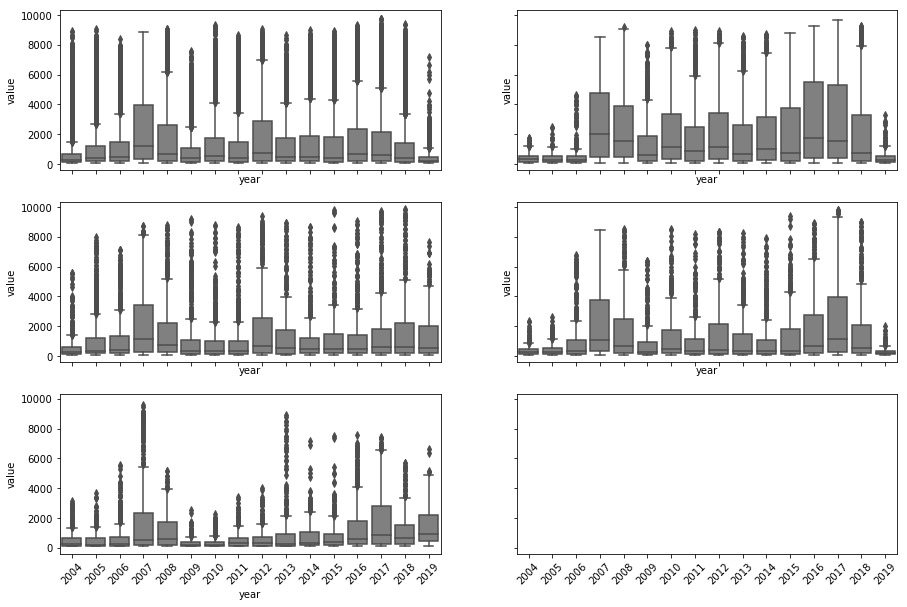

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
for var, subplot in zip(categorical, ax.flatten()):
    cluster_df = clus_data(file_list, prob_list, cluster, var)
    sns.boxplot(data=cluster_df, x='year', y='value', ax=subplot, color="gray")

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

In [261]:
#individual
# cluster1 = clus_data(file_list, prob_list, cluster, 2)
# sns.boxplot(data=cluster1, x='year', y='value')

### part 3

In [48]:
import glob 
import rasterio
import os
from math import floor, ceil
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import datetime
import math

In [100]:
def clus_probstats(n_labels, n_years, pred_list, prob_list, cluster_raster, cluster_val):
    mask = np.array(cluster_raster.read(1) == cluster_val)
    
    prob_list = [maskclu(x, mask) for x in prob_list]
    prob_stack = np.ma.stack(prob_list)
    prob_stack = prob_stack[:23*n_years,:,:]
    
    prob_stack_reshape = prob_stack.reshape(n_years, 23, prob_stack.shape[1], prob_stack.shape[2])
    
    prob_mean = np.mean(prob_stack_reshape, axis = 1)
    prob_min = np.min(prob_stack_reshape, axis = 1)
    prob_max = np.max(prob_stack_reshape, axis = 1)

    #reshape
    z = clust_stack.reshape((clust_stack.shape[0],clust_stack.shape[1]*clust_stack.shape[2]))
    
    tS = '2004-01-01'
    tE = '2018-01-01'
    
    df = pd.DataFrame(np.ma.compress_rowcols(z, axis=1), index= pd.date_range(tS, tE, freq = 'A'))
    
    data=pd.melt(df.T)
    
    data = data.set_index(pd.DatetimeIndex(pd.to_datetime(data['variable'])))
    data['year'] = data.index.year
    
    mask = np.array(cluster_raster.read(1) == cluster_val)

    pred_list = [maskclu(x, mask) for x in pred_list]
    pred_stack = np.ma.stack(pred_list)

    pred_stack = np.reshape(pred_stack, (n_labels,n_years,array_stack.shape[1],array_stack.shape[2]))
    pred_stack = pred_stack[2,:,:,:]
    
    z = pred_stack.reshape((pred_stack.shape[0],pred_stack.shape[1]*pred_stack.shape[2]))

    df = pd.DataFrame(np.ma.compress_rowcols(z, axis=1), index= pd.date_range(tS, tE, freq = 'A'))
    
    data2=pd.melt(df.T)
    
    data2 = data2.set_index(pd.DatetimeIndex(pd.to_datetime(data2['variable'])))
    data2['year'] = data2.index.year
    
    return(data, data2)

In [123]:
def clus_probstats2(n_labels, n_years, pred_list, prob_list, cluster_raster, cluster_val):
    mask = np.array(cluster_raster.read(1) == cluster_val)
    
    prob_list = [maskclu(x, mask) for x in prob_list]
    prob_stack = np.ma.stack(prob_list)
    prob_stack = prob_stack[:23*n_years,:,:]
    
    prob_stack_reshape = prob_stack.reshape(n_years, 23, prob_stack.shape[1], prob_stack.shape[2])
    
    prob_mean = np.mean(prob_stack_reshape, axis = 1)
    prob_min = np.min(prob_stack_reshape, axis = 1)
    prob_max = np.max(prob_stack_reshape, axis = 1)

    #reshape
    z = prob_stack.reshape((prob_stack.shape[0],prob_stack.shape[1]*prob_stack.shape[2]))
    
    tS = '2004-01-01'
    tE = '2018-01-01'
    
    df = pd.DataFrame(np.ma.compress_rowcols(z, axis=1), index= pd.date_range(tS, tE, freq = 'A'))
    
    data=pd.melt(df.T)
    
    data = data.set_index(pd.DatetimeIndex(pd.to_datetime(data['variable'])))
    data['year'] = data.index.year
    
    mask = np.array(cluster_raster.read(1) == cluster_val)

    pred_list = [maskclu(x, mask) for x in pred_list]
    pred_stack = np.ma.stack(pred_list)

    pred_stack = np.reshape(pred_stack, (n_labels,n_years,array_stack.shape[1],array_stack.shape[2]))
    pred_stack = pred_stack[2,:,:,:]
    
    z = pred_stack.reshape((pred_stack.shape[0],pred_stack.shape[1]*pred_stack.shape[2]))

    df = pd.DataFrame(np.ma.compress_rowcols(z, axis=1), index= pd.date_range(tS, tE, freq = 'A'))
    
    data2=pd.melt(df.T)
    
    data2 = data2.set_index(pd.DatetimeIndex(pd.to_datetime(data2['variable'])))
    data2['year'] = data2.index.year
    
    return(data, data2)

In [51]:
detprob = r"E:\acocac\research\tile3\eval\pred\7_dataset\ep10\convgru\convgru64_15_fold0_Copernicusraw_24257"
probdir = r"E:\acocac\research\tile3\terrai\ascii\h10v08\merge"
clu_fn = r"E:\acocac\research\tile3\clusters\cluster_clcp_Copernicusraw_2010-2010_raw_c5.asc"

In [3]:
n_years = 14
scheme = 'Copernicusraw'

if scheme == 'MCD12Q1v6raw_LCType1':
    n_labels = 17
elif scheme == 'MCD12Q1v6raw_LCProp1':
    n_labels = 16
elif scheme == 'MCD12Q1v6raw_LCProp2':
    n_labels = 11
elif scheme == 'ESAraw':
    n_labels = 37
elif scheme == 'Copernicusraw':
    n_labels = 22

In [108]:
file_list = glob.glob(os.path.join(probdir, '*.asc'))

# Read all data as a list of numpy arrays 
# prob_list = [read_file(lon, lat, x) for x in file_list]
prob_list = [read_file_regular(x) for x in file_list]

prob_stack = np.stack(prob_list)
# prob_stack = prob_stack[:23*n_years,:,:]

In [109]:
prob_stack = prob_stack[:23*n_years,:,:]

In [110]:
prob_stack_reshape = prob_stack.reshape(n_years, 23, prob_stack.shape[1],prob_stack.shape[2])

In [111]:
prob_stack_reshape.shape

(14, 23, 384, 384)

In [112]:
prob_mean = np.mean(prob_stack_reshape, axis = 1)
prob_max = np.max(prob_stack_reshape, axis = 1)
prob_min = np.min(prob_stack_reshape, axis = 1)

In [113]:
prob_min.shape

(14, 384, 384)

In [114]:
file_list = glob.glob(os.path.join(detprob,'*/confidences/**/*.tif'))
file_list = sorted(file_list, key=lambda x: int(os.path.basename(os.path.dirname(x)).partition('_')[0]))

In [87]:
# pred_list = [read_file(lon, lat, x) for x in file_list]

In [115]:
pred_list = [read_file_regular(x) for x in file_list] 

In [116]:
pred_stack = np.stack(pred_list)
# pred_stack = pred_stack[:23*n_years,:,:]

In [117]:
pred_stack_reshape = pred_stack.reshape(n_years, 22, pred_stack.shape[1],pred_stack.shape[2])

In [118]:
    mask = np.array(cluster_raster.read(1) == cluster_val)

    pred_list = [maskclu(x, mask) for x in pred_list]

(308, 384, 384)

In [122]:
b = clus_probstats2(n_labels, n_years, pred_list, prob_list, cluster, 1)

NameError: name 'clust_stack' is not defined

In [52]:
cluster_val=1
mask = np.array(cluster_raster.read(1) == cluster_val)

prob_list = [maskclu(x, mask) for x in prob_list]
prob_stack = np.ma.stack(prob_list)
prob_stack = prob_stack[:23*n_years,:,:]

prob_stack_reshape = prob_stack.reshape(n_years, 23, prob_stack.shape[1], prob_stack.shape[2])

prob_mean = np.mean(prob_stack_reshape, axis = 1)
prob_min = np.min(prob_stack_reshape, axis = 1)
prob_max = np.max(prob_stack_reshape, axis = 1)

z_mean = prob_mean.reshape((prob_mean.shape[0],prob_mean.shape[1]*prob_mean.shape[2]))
z_min = prob_min.reshape((prob_min.shape[0],prob_min.shape[1]*prob_min.shape[2]))
z = prob_max.reshape((prob_max.shape[0],prob_max.shape[1]*prob_max.shape[2]))

pred_list = [maskclu(x, mask) for x in pred_list]
pred_stack = np.ma.stack(pred_list)

pred_stack = np.reshape(pred_stack, (n_labels,n_years,pred_stack.shape[1],pred_stack.shape[2]))
pred_stack2 = pred_stack[2,:,:,:]

(383, 378)


MaskError: Mask and data not compatible: data size is 147456, mask size is 144774.

In [13]:
def maskclu(array, mask):
    return(np.ma.array(array, mask = ~mask))

In [11]:
def read_file_regular(file):
    with rasterio.open(file) as src:
        return(src.read(1))

In [65]:
from dateutil.relativedelta import relativedelta



14

In [81]:
def extract_by_cluster(cluster_number, clu_file, probdir, detprob, tS, tE):
    
    tS = pd.to_datetime('2004-01-01')
    tE = pd.to_datetime('2018-01-01')

    nyears = int(pd.Series(tE-tS)/np.timedelta64(1,'Y'))
    cluster_val=cluster_number

    cluster_raster =  rasterio.open(clu_fn)
    mask = np.array(cluster_raster.read(1) == cluster_val)

    file_list = glob.glob(os.path.join(probdir, '*.asc'))

    prob_list = [read_file_regular(x) for x in file_list]
    prob_list = [maskclu(x, mask) for x in prob_list]
    prob_stack = np.ma.stack(prob_list)
    prob_stack = prob_stack[:23*n_years,:,:]

    prob_stack_reshape = prob_stack.reshape(n_years, 23, prob_stack.shape[1], prob_stack.shape[2])

    prob_mean = np.mean(prob_stack_reshape, axis = 1)
    z = prob_mean.reshape((prob_mean.shape[0],prob_mean.shape[1]*prob_mean.shape[2]))

    df = pd.DataFrame(np.ma.compress_rowcols(z, axis=1), index= pd.date_range(tS, tE, freq = 'A'))

    data=pd.melt(df.T)

    file_list = glob.glob(os.path.join(detprob,'*/confidences/**/*.tif'))
    file_list = sorted(file_list, key=lambda x: int(os.path.basename(os.path.dirname(x)).partition('_')[0]))

    pred_list = [read_file_regular(x) for x in file_list]
    pred_list = [maskclu(x, mask) for x in pred_list]
    pred_stack = np.ma.stack(pred_list)

    pred_stack = np.reshape(pred_stack, (n_labels,n_years,pred_stack.shape[1]*pred_stack.shape[2]))
    pred_stack2 = pred_stack[2,:,:]

    df_pred = pd.DataFrame(np.ma.compress_rowcols(pred_stack2, axis=1), index= pd.date_range(tS, tE, freq = 'A'))

    data_pred=pd.melt(df_pred.T)

    mergedf = data.merge(data_pred, left_index=True, right_index=True)
    mergedf['cluster'] = cluster_number
    return(mergedf)

In [80]:
import seaborn as sns
import pandas as pd
import numpy as np

tS = '2004-01-01'
tE = '2018-01-01'
cluster_number = 3

mergedf = extract_by_cluster(cluster_number, clu_fn, probdir, detprob, tS, tE)

# sns.pairplot(x_vars=["value_y"], y_vars=["value_x"], data=mergedf[mergedf.variable_x == '2010-12-31'], hue="variable_x", size=5)
sns.pointplot(x=["value_y"], y=["value_x"], data=mergedf, hue="variable_x", ax=subplot)

TypeError: Argument 'obj' has incorrect type (expected list, got DataFrame)

In [82]:
categorical = range(2,6)

mergedfALL = extract_by_cluster(1, clu_fn, probdir, detprob, tS, tE)

for c in categorical:
    mergedf = extract_by_cluster(var, clu_fn, probdir, detprob, tS, tE)
    mergedfALL = pd.concat([mergedfALL, mergedf])

In [88]:
mergedf.cluster

0       1
1       1
2       1
3       1
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      1
13      1
14      1
15      1
16      1
17      1
18      1
19      1
20      1
21      1
22      1
23      1
24      1
25      1
26      1
27      1
28      1
29      1
       ..
2504    1
2505    1
2506    1
2507    1
2508    1
2509    1
2510    1
2511    1
2512    1
2513    1
2514    1
2515    1
2516    1
2517    1
2518    1
2519    1
2520    1
2521    1
2522    1
2523    1
2524    1
2525    1
2526    1
2527    1
2528    1
2529    1
2530    1
2531    1
2532    1
2533    1
Name: cluster, Length: 2534, dtype: int64

(2534, 4)


TypeError: Argument 'obj' has incorrect type (expected list, got DataFrame)

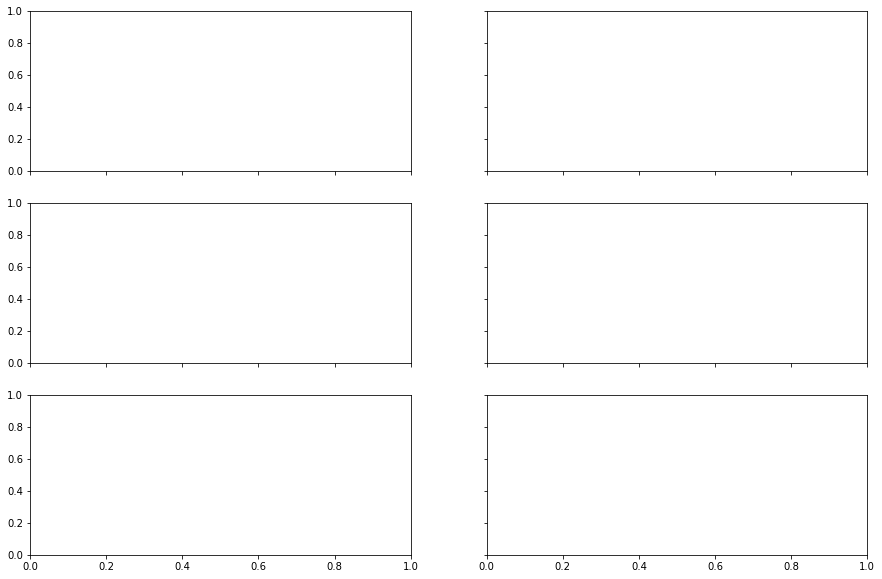

In [79]:
categorical = range(1,6)

fig, ax = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
for var, subplot in zip(categorical, ax.flatten()):
    mergedf = extract_by_cluster(var, clu_fn, probdir, detprob, tS, tE)
    print(mergedf.shape)
#     sns.pairplot(x_vars=["value_y"], y_vars=["value_x"], data=mergedf[mergedf.variable_x == '2010-12-31'], hue="variable_x", size=5, ax=subplot)
    sns.pointplot(x=["value_y"], y=["value_x"], data=mergedf, hue="variable_x", ax=subplot)

#     sns.boxplot(data=cluster_df, x='year', y='value', ax=subplot, color="gray")

# for ax in fig.axes:
#     plt.sca(ax)
#     plt.xticks(rotation=45)